<a href="https://colab.research.google.com/github/ayushm-agrawal/Federated-Learning-Implementations/blob/master/FederatedAveraging.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [124]:
%load_ext tensorboard
import os
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import copy
import random
import time
import csv

import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.utils.data import Dataset, DataLoader
from torch.utils.tensorboard import SummaryWriter
from torchvision import transforms, utils, datasets
from torchsummary import summary
from collections import defaultdict

# Check assigned GPU
# CPUA makes things run faster
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

# set manual seed for reproducibility
seed = 47

# general reproducibility
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

# gpu training specific
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard
Wed Sep 28 02:04:09 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 517.48       Driver Version: 517.48       CUDA Version: 11.7     |
|-------------------------------+----------------------+----------------------+
| GPU  Name            TCC/WDDM | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ... WDDM  | 00000000:02:00.0  On |                  N/A |
| 30%   50C    P0    42W / 200W |   4589MiB /  8192MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------

## Load the MNIST Dataset

In [125]:
# create transforms
# We will just convert to tensor and normalize since no special transforms are mentioned in the paper
transforms_mnist = transforms.Compose([
                                       transforms.ToTensor(),
                                       transforms.Normalize((0.1307,), (0.3081,))
                                       ])

mnist_data_train = datasets.MNIST('./data/mnist/', train=True, download=True, transform=transforms_mnist)
mnist_data_test = datasets.MNIST('../data/mnist/', train=False, download=True, transform=transforms_mnist)

In [126]:
classes = np.array(list(mnist_data_train.class_to_idx.values()))
classes_test = np.array(list(mnist_data_test.class_to_idx.values()))
num_classes = len(classes_test)
print("Classes: {} \tType: {}".format(classes, type(classes)))
print("Classes Test: {} \tType: {}".format(classes_test, type(classes)))


Classes: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>
Classes Test: [0 1 2 3 4 5 6 7 8 9] 	Type: <class 'numpy.ndarray'>


In [127]:
print("Image Shape: {}".format(mnist_data_train.data[0].size()))

Image Shape: torch.Size([28, 28])


## Visualize Data

In [128]:
def imshow(img):
	img = img/2 + 0.5 #unnormalize the image
	plt.imshow(img, cmap='gray') # convert from tensor to image

In [129]:
def visualize(dataset):
  figure = plt.figure(figsize=(25,4))
  for i in range(20):
    axis = figure.add_subplot(int(2), int(20/2), int(i+1), xticks=[], yticks=[])
    data = dataset.data[i]
    data = data.numpy()

    target = dataset.targets[i]
    target = target.numpy()
    imshow(data)
    axis.set_title(target)


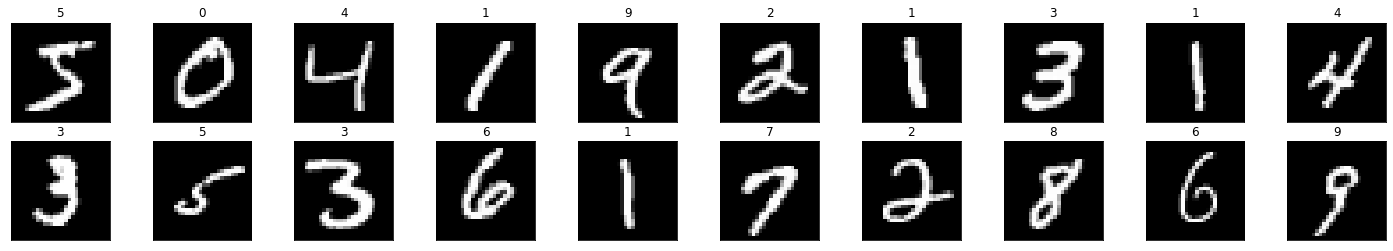

In [130]:
visualize(mnist_data_train)

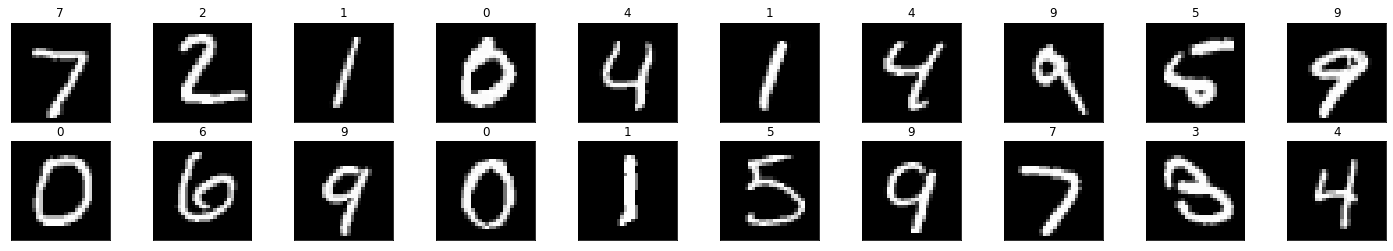

In [131]:
visualize(mnist_data_test)

## Partitioning the Data (IID and non-IID)

In [132]:
def iid_partition(dataset, clients):
  """
  I.I.D paritioning of data over clients
  Shuffle the data
  Split it between clients
  
  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between

  returns:
    - Dictionary of image indexes for each client
  """

  num_items_per_client = int(len(dataset)/clients)
  client_dict = {}
  image_idxs = [i for i in range(len(dataset))]

  for i in range(clients):
    np.random.seed(seed)
    client_dict[i] = set(np.random.choice(image_idxs, num_items_per_client, replace=False))
    image_idxs = list(set(image_idxs) - client_dict[i])

  return client_dict

In [133]:
def non_iid_partition(dataset, clients, total_shards, shards_size, num_shards_per_client):
  """
  non I.I.D parititioning of data over clients
  Sort the data by the digit label
  Divide the data into N shards of size S
  Each of the clients will get X shards

  params:
    - dataset (torch.utils.Dataset): Dataset containing the MNIST Images
    - clients (int): Number of Clients to split the data between
    - total_shards (int): Number of shards to partition the data in
    - shards_size (int): Size of each shard 
    - num_shards_per_client (int): Number of shards of size shards_size that each client receives

  returns:
    - Dictionary of image indexes for each client
  """
  
  shard_idxs = [i for i in range(total_shards)]
  client_dict = {i: np.array([], dtype='int64') for i in range(clients)}
  idxs = np.arange(len(dataset))
  data_labels = dataset.targets.numpy()

  # sort the labels
  label_idxs = np.vstack((idxs, data_labels))
  label_idxs = label_idxs[:, label_idxs[1,:].argsort()]
  idxs = label_idxs[0,:]

  # divide the data into total_shards of size shards_size
  # assign num_shards_per_client to each client
  for i in range(clients):
    np.random.seed(seed)
    rand_set = set(np.random.choice(shard_idxs, num_shards_per_client, replace=False))
    shard_idxs = list(set(shard_idxs) - rand_set)

    for rand in rand_set:
      client_dict[i] = np.concatenate((client_dict[i], idxs[rand*shards_size:(rand+1)*shards_size]), axis=0)
  
  return client_dict





## Models

In [134]:
class MNIST_CNN_S(nn.Module):
  """
  CNN with two 5x5 convolution lauers(the first with 32 channels, second with 64,
  each followed with 2x2 max pooling), a fully connected layer with 512 uunits and 
  ReLu activation, and the final Softmax output layer

  Total Expected Params: 1,663,370
  """
  def __init__(self):
    super(MNIST_CNN_S, self).__init__()

    self.conv1 = nn.Conv2d(1, 32, kernel_size=5)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5)
    
    self.pool = nn.MaxPool2d(2,2)
    self.dropout = nn.Dropout(p=0.5)

    self.fc1 = nn.Linear(1024, 512)
    self.out = nn.Linear(512, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
    x = self.dropout(x)
    x = self.out(x)
    out = F.log_softmax(x, dim=1)

    return out

In [135]:
class CIFAR_CNN(nn.Module):
  """
  CNN with two 5x5 convolution lauers(the first with 32 channels, second with 64,
  each followed with 2x2 max pooling), a fully connected layer with 512 uunits and 
  ReLu activation, and the final Softmax output layer

  Total Expected Params: 1,663,370
  """
  # nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
  def __init__(self):
    super(CIFAR_CNN, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
    self.batchnorm1 = nn.BatchNorm2d(32)
    self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
    self.batchnorm2 = nn.BatchNorm2d(64)    
    self.pool = nn.MaxPool2d(2,2)
#     self.dropout2 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(3136, 512)
    self.out = nn.Linear(512, 10)
#     self.dropout1 = nn.Dropout(0.5)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.batchnorm1(x)
    x = self.pool(F.relu(self.conv2(x)))
    x = self.batchnorm2(x)
    x = torch.flatten(x, 1)
    x = F.relu(self.fc1(x))
#     x = self.dropout2(x)
#     x = self.dropout1(x)
    x = self.out(x)
    out = F.log_softmax(x, dim=1)

    return out

    


In [136]:
class MNIST_CNN(nn.Module):
  """
  CNN with two 5x5 convolution lauers(the first with 32 channels, second with 64,
  each followed with 2x2 max pooling), a fully connected layer with 512 uunits and 
  ReLu activation, and the final Softmax output layer

  Total Expected Params: 1,663,370
  """
  # nn.Conv2d(in_channels, out_channels, kernel_size, stride=1, padding=0, dilation=1, groups=1, bias=True, padding_mode='zeros')
  def __init__(self):
    super(MNIST_CNN, self).__init__()

    self.conv1 = nn.Conv2d(1, 8, kernel_size=5, stride=1, padding=2)
    self.conv2 = nn.Conv2d(8, 16, kernel_size=5, stride=1, padding=2)
    self.pool = nn.MaxPool2d(2,2)
    self.dropout1 = nn.Dropout(0.5)
    self.fc1 = nn.Linear(784, 32)
    self.fc2 = nn.Linear(32, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.dropout1(x)
    x = torch.flatten(x, 1)
    x = self.fc1(x)
    x = F.relu(x)
    x = self.fc2(x)
    output = F.log_softmax(x, dim=1)
    return output

#     self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2)
#     self.conv2 = nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2)
    
#     self.pool = nn.MaxPool2d(2,2)
#     self.dropout1 = nn.Dropout(p=0.25)
#     self.dropout2 = nn.Dropout(p=0.25)
#     self.fc1 = nn.Linear(3136, 512)
#     self.out = nn.Linear(512, 10)

#   def forward(self, x):
#     x = self.pool(F.relu(self.conv1(x)))
#     x = self.pool(F.relu(self.conv2(x)))
#     x = self.dropout1(x)
#     x = torch.flatten(x, 1)
#     x = F.relu(self.fc1(x))
#     x = self.dropout2(x)
#     x = self.out(x)
#     out = F.log_softmax(x, dim=1)

#     return out

### Print Model Summaries

In [137]:
cifar_cnn = CIFAR_CNN()
mnist_cnn = MNIST_CNN()
mnist_cnn_s = MNIST_CNN_S()

if torch.cuda.is_available():
  cifar_cnn.cuda()
  mnist_cnn.cuda()
  mnist_cnn_s.cuda()    

print("\nCIFAR CNN SUMMARY")
print(summary(cifar_cnn, (1, 28, 28)))
    
print("\nMNIST CNN SUMMARY")
print(summary(mnist_cnn, (1, 28, 28)))

print("\nMNIST CNN S SUMMARY")
print(summary(mnist_cnn_s, (1, 28, 28)))


CIFAR CNN SUMMARY
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                            [-1, 32, 28, 28]          832
├─MaxPool2d: 1-2                         [-1, 32, 14, 14]          --
├─BatchNorm2d: 1-3                       [-1, 32, 14, 14]          64
├─Conv2d: 1-4                            [-1, 64, 14, 14]          51,264
├─MaxPool2d: 1-5                         [-1, 64, 7, 7]            --
├─BatchNorm2d: 1-6                       [-1, 64, 7, 7]            128
├─Linear: 1-7                            [-1, 512]                 1,606,144
├─Linear: 1-8                            [-1, 10]                  5,130
Total params: 1,663,562
Trainable params: 1,663,562
Non-trainable params: 0
Total mult-adds (M): 12.27
Input size (MB): 0.00
Forward/backward pass size (MB): 0.36
Params size (MB): 6.35
Estimated Total Size (MB): 6.71
Layer (type:depth-idx)                   Output Shape              Param #
├─Conv2d: 1-1                        

## Federated Averaging

### Testing Loop

In [138]:
def testing_loop(model, dataset, bs, criterion, num_classes, classes):
  #test loss 
  test_loss = 0.0
  correct_class = list(0. for i in range(num_classes))
  total_class = list(0. for i in range(num_classes))

  test_loader = DataLoader(dataset, batch_size=bs, pin_memory=True)
  l = len(test_loader)
  model.eval()
  for data, labels in test_loader:
        
    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()
        
    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    #test accuracy for each object class
    for i in range(num_classes):
      label = labels.data[i]
      correct_class[label] += correct[i].item()
      total_class[label] += 1
    
  # avg test loss
  test_loss = test_loss/len(test_loader.dataset)

  test_accuracy = 100. * np.sum(correct_class) / np.sum(total_class)

  return test_loss, test_accuracy

### Local Training (Client Update)

Local training for the model on client side

In [139]:
class CustomDataset(Dataset):
  def __init__(self, dataset, idxs):
      self.dataset = dataset
      self.idxs = list(idxs)

  def __len__(self):
      return len(self.idxs)

  def __getitem__(self, item):
      image, label = self.dataset[self.idxs[item]]
      return image, label

class ClientUpdate(object):
  def __init__(self, dataset, batchSize, learning_rate, epochs, idxs):
    self.train_loader = DataLoader(CustomDataset(dataset, idxs), batch_size=batchSize, shuffle=True, pin_memory=True)
    self.learning_rate = learning_rate
    self.epochs = epochs

  def train(self, model):

    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=self.learning_rate, momentum=0.5)
    # optimizer = torch.optim.Adam(model.parameters(), lr=self.learning_rate)

    e_loss = []
    for epoch in range(1, self.epochs+1):

      train_loss = 0.0
      model.train()
      for data, labels in self.train_loader:
        if torch.cuda.is_available():
            data, labels = data.cuda(), labels.cuda()
        # clear the gradients
        optimizer.zero_grad()
        # make a forward pass
        output = model(data)
        # calculate the loss
        loss = criterion(output, labels)
        # do a backwards pass
        loss.backward()
        # perform a single optimization step
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)            
            
      #print('Cur Battery: {}...'.format(self.battery))
      #print('Final Battery: {}...'.format(self.battery))
      # average losses
      train_loss = train_loss/len(self.train_loader.dataset)
      e_loss.append(train_loss)

    total_loss = sum(e_loss)/len(e_loss)

    return model.state_dict(), total_loss

### Server Side Training

Following Algorithm 1 from the paper

In [140]:
def training(model, rounds, batch_size, lr, ds, data_dict, CLIENT_FRACTION, TOTAL_CLIENTS, TRAINING_EPOCHS,\
             LOWP_TRAINING_EPOCHS, HIGHP_CLIENT_PERCENTAGE, plt_title, plt_color):
  """
  Function implements the Federated Averaging Algorithm from the FedAvg paper.
  Specifically, this function is used for the server side training and weight update

  Params:
    - model:                    PyTorch model to train
    - rounds:                   Number of communication rounds for the client update
    - batch_size:               Batch size for client update training
    - lr:                       Learning rate used for client update training
    - ds:                       Dataset used for training
    - data_dict:                Type of data partition used for training (IID or non-IID)
    - CLIENT_FRACTION:          Fraction of clients randomly chosen to perform computation on each round
    - TOTAL_CLIENTS:            Total number of clients
    - TRAINING_EPOCHS:          Number of training passes each client makes over its local dataset per round
    - HIGHP_CLIENT_PERCENTAGE:  High/Low battery distribution   
    - tb_writer_name:           Directory name to save the tensorboard logs
  Returns:  
    - model:                Trained model on the server
  """ 

  # global model weights
  global_weights = model.state_dict()

  # training loss
  train_loss = []

  # test accuracy
  test_acc = []

  # index of clients deleted for low battery
  deleted_clients = []

  xaxiss = 0
  break_counter = 0
  
  # measure time
  start = time.time()
    
  # create list of dictionary for dict_id, battery, sim-martix
  client_info = [{} for sub in range(TOTAL_CLIENTS)]


  # initialize all client battery
  np.random.seed(seed)
  LOWP_CLIENTS = np.random.uniform(low=30.0, high=35.0, size=round((1-HIGHP_CLIENT_PERCENTAGE)*TOTAL_CLIENTS))  
  HIGHP_CLIENTS = np.random.uniform(low=80.0, high=100.0, size=int(HIGHP_CLIENT_PERCENTAGE*TOTAL_CLIENTS)) 
  CLIENTS_BATTERY = np.concatenate((LOWP_CLIENTS, HIGHP_CLIENTS), axis=0)
  np.random.shuffle(CLIENTS_BATTERY)
    
  # add all client battery to dict
  for ids, currdict in enumerate(client_info):
    currdict['ID']=ids
    currdict['Battery']=CLIENTS_BATTERY[ids]
    currdict['Round_trained']=0
    currdict['Matrix'] = []


  for curr_round in range(1, rounds+1):
    
    w, local_loss = [], []

    NUM_CLIENTS = max(int(CLIENT_FRACTION*TOTAL_CLIENTS), 1)

    np.random.seed(seed)
    BATTERY_COST = np.random.uniform(0.8, 1, TOTAL_CLIENTS)
        
    width, height = len(client_info), len(client_info)

    
    TRAINING_CLIENTS = []
    
    # break if the clients left are all high power client  
    if(len(client_info) == len(HIGHP_CLIENTS)):
      break_counter += 1
#       xaxiss = curr_round
#       break
      if break_counter==10:
        xaxiss = curr_round
        break

#     #getting the first matrix
#     if curr_round==1:
#       matrix_counter = len(client_info)
#       # Creates the matrix
# #       allw = [[0 for x in range(width)] for y in range(height)] 
#       allw = np.zeros((width, height))
#       # Going through all clients and calculate the similarity matrix for all clients
#       for ids, curr_client in enumerate(client_info):
#         output = []
#         # Get weights for all clients
#         local_update = ClientUpdate(mnist_data_train, batch_size, lr, 1, data_dict[currdict['ID']])
#         matrix_weights, matrix_loss = local_update.train(model=copy.deepcopy(model))
#         matrix_counter-=1
#         dict_id = ids
#         for k in matrix_weights.keys():
#           output += list(np.array(torch.flatten(matrix_weights[k]).detach().cpu().numpy()))
#         allw[ids][ids] = np.vdot(output, output)
#         for i in range (matrix_counter):
#           dict_id+=1
#           local_update = ClientUpdate(mnist_data_train, batch_size, lr, 1, data_dict[dict_id])
#           weights_temp, loss_temp = local_update.train(model=copy.deepcopy(model))
# #           dict_id+=1
#           output1 = []
#           for k in weights_temp.keys():
#             output1 += list(np.array(torch.flatten(weights_temp[k]).detach().cpu().numpy()))
#           allw[ids][dict_id] = np.vdot(output, output1)
#     all_matrix = [[] for i in range(len(client_info))]    
    #getting the first matrix
    
    if curr_round==1:
      matrix_counter = len(client_info)
      # Creates the matrix
#       allw = [[0 for x in range(width)] for y in range(height)] 
      allw = np.zeros((width, height))
      # Going through all client_info and find the client that have recently enough matrix use them instead of finding new
      for i in range(len(client_info)):
        local_update = ClientUpdate(mnist_data_train, batch_size, lr, 1, data_dict[client_info[i]['ID']])
        matrix_weights, matrix_loss = local_update.train(model=copy.deepcopy(model))
        for k in matrix_weights.keys():
          client_info[i]['Matrix'] += list(np.array(torch.flatten(matrix_weights[k]).detach().cpu().numpy()))
        client_info[i]['Battery'] -= np.random.uniform(0.4, 0.5)
      
       # Going through all clients and calculate the similarity matrix for all clients
      for ids, curr_client in enumerate(client_info):        
        matrix_counter-=1
        dict_id = ids
#         print("ROUND 1")
#         print(len(client_info[ids]['Matrix']))
        allw[ids][ids] = np.vdot(client_info[ids]['Matrix'], client_info[ids]['Matrix'])
        for i in range (matrix_counter):
          dict_id+=1
          allw[ids][dict_id] = np.vdot(client_info[ids]['Matrix'], client_info[dict_id]['Matrix'])        
      #normalize all the clients weight     
      for i in range(width):
        temp_max = np.amax(allw[i])
#       temp_max = allw[i][i]
        for j in range(height):
          if allw[i][j] != 0:
            allw[i][j] = allw[i][j]/temp_max

      #enter the weights into each clients' row     
      for i in range(width):
        for j in range(height):
          if allw[i][j] == 0:
            allw[i][j] = allw[j][i]
        
      #get total similarity matrix by adding the local weights of each client together    
      total_wmatrix =[]
      for i in range(width):
        temprow=0
        for j in range(height):
          temprow += allw[i][j]
        total_wmatrix.append(temprow)
#       print(allw)
      #update the weights info to the client dict
#       for ids, currdict in enumerate(client_info):
#         currdict['Matrix']=total_wmatrix[ids]
    
      client_info = sorted(client_info, key=lambda x: x['Matrix'])
      
    
    #every 5 rounds will get matrix
    elif curr_round%3==0:
      matrix_counter = len(client_info)
      # Creates the matrix
#       allw = [[0 for x in range(width)] for y in range(height)] 
      allw = np.zeros((width, height))
      # Going through all client_info and find the client that have recently enough matrix use them instead of finding new
      for i in range(len(client_info)):
        if client_info[i]['Round_trained'] == 0:
#           print("NONONONNN")
          local_update = ClientUpdate(mnist_data_train, batch_size, lr, 1, data_dict[client_info[i]['ID']])
          matrix_weights, matrix_loss = local_update.train(model=copy.deepcopy(model))
          client_info[i]['Matrix'].clear()
          for k in matrix_weights.keys():
            client_info[i]['Matrix'] += list(np.array(torch.flatten(matrix_weights[k]).detach().cpu().numpy()))
        client_info[i]['Battery'] -= np.random.uniform(0.4, 0.5)
  
      # Going through all clients and calculate the similarity matrix for all clients
      for ids, curr_client in enumerate(client_info):        
        matrix_counter-=1
        dict_id = ids
#         print("ROUND 3ish round")
#         print(len(client_info[ids]['Matrix']),ids)
#         print("wenti???")
        allw[ids][ids] = np.vdot(client_info[ids]['Matrix'], client_info[ids]['Matrix'])
        for i in range (matrix_counter):
          dict_id+=1
#           print(len(client_info[dict_id]['Matrix']),dict_id)
          allw[ids][dict_id] = np.vdot(client_info[ids]['Matrix'], client_info[dict_id]['Matrix'])     
      
        
 
      #normalize all the clients weight     
      for i in range(width):
        temp_max = np.amax(allw[i])
#       temp_max = allw[i][i]
        for j in range(height):
          if allw[i][j] != 0:
            allw[i][j] = allw[i][j]/temp_max

      #enter the weights into each clients' row     
      for i in range(width):
        for j in range(height):
          if allw[i][j] == 0:
            allw[i][j] = allw[j][i]
        
      #get total similarity matrix by adding the local weights of each client together    
      total_wmatrix =[]
      for i in range(width):
        temprow=0
        for j in range(height):
          temprow += allw[i][j]
        total_wmatrix.append(temprow)
#       print(allw)
      #update the weights info to the client dict
#       for ids, currdict in enumerate(client_info):
#         currdict['Matrix']=total_wmatrix[ids]
    
      client_info = sorted(client_info, key=lambda x: x['Matrix'])
        
      #Pick the client that scores the lowest similarity score
      #TRAINING_CLIENTS = np.random.choice(range(TOTAL_CLIENTS), NUM_CLIENTS, replace=False)
#       sorted_wmatrix = sorted(enumerate(total_wmatrix), key=lambda i: i[1])
      #comparing the top 2 clients' difference with the matrix average
#       wights_difavg = (client_info[1]['Matrix']-client_info[0]['Matrix'])
      
    # get the clients for training this round  
#     half_c = max(int(len(client_info)/2),1)
#     full_c = k = max(int(len(client_info)),1) 
    temp_tClients = []
    for i in range(len(client_info)):
      if (curr_round > (client_info[i]['Round_trained']+3) or client_info[i]['Round_trained']==0):
        TRAINING_CLIENTS.append(client_info[i]['ID'])
        client_info[i]['Round_trained'] = curr_round
        if(len(TRAINING_CLIENTS) == NUM_CLIENTS/2):
          temp_tClients.append(client_info[i]['ID'])
          break
        
    for i in range(len(client_info)-1, -1, -1):
      if (curr_round > (client_info[i]['Round_trained']+3) or client_info[i]['Round_trained']==0) and client_info[i]['ID']\
      not in temp_tClients:
        TRAINING_CLIENTS.append(client_info[i]['ID'])
        client_info[i]['Round_trained'] = curr_round
        if(len(TRAINING_CLIENTS) == NUM_CLIENTS):
          break
    if len(TRAINING_CLIENTS)<NUM_CLIENTS:
      for i in range(len(client_info)-1, -1, -1):
        TRAINING_CLIENTS.append(client_info[i]['ID'])
        client_info[i]['Round_trained'] = curr_round     
        if(len(TRAINING_CLIENTS) == NUM_CLIENTS):
          break
#     if len(TRAINING_CLIENTS) != NUM_CLIENTS or TRAINING_CLIENTS is False:
#       TRAINING_CLIENTS.clear() 
#       TRAINING_CLIENTS.append(client_info[0]['ID'])
#       client_info[0]['Round_trained'] = curr_round  
#       temp_last=len(TRAINING_CLIENTS) -1
#       TRAINING_CLIENTS.append(client_info[temp_last]['ID'])
#       client_info[temp_last]['Round_trained'] = curr_round
      
              
#     #if there are still clients left but cooldown too long
#     if (len(client_info) <= (len(HIGHP_CLIENTS)+3)) and (len(TRAINING_CLIENTS) != NUM_CLIENTS):
#       print("When avaiable client too low for 3 cooldown...")
#       for i in range(len(client_info)):
# #         if curr_round > (client_info[i]['Round_trained']+1) or client_info[i]['Round_trained']==0:
#         if curr_round > (client_info[i]['Round_trained']+1) or client_info[i]['Round_trained']==0 and i%2 == 0:
#           TRAINING_CLIENTS.append(client_info[i]['ID'])
#           client_info[i]['Round_trained'] = curr_round
#           if(len(TRAINING_CLIENTS) == NUM_CLIENTS):
#             break      
#         elif curr_round > (client_info[i]['Round_trained']+1) or client_info[i]['Round_trained']==0 and i%2 == 1:
#           TRAINING_CLIENTS.append(client_info[i]['ID'])
#           client_info[i]['Round_trained'] = curr_round
#           if(len(TRAINING_CLIENTS) == NUM_CLIENTS):
#             break     
    
   
        

#     curr_index = 0
#     for i in range(NUM_CLIENTS):
#       if (client_info[curr_index+1][1]-client_info[curr_index][1] < wights_difavg) and CLIENTS_BATTERY[curr_index] < 30\
#       and CLIENTS_BATTERY[curr_index+1] >= 30:
#         TRAINING_CLIENTS.append(client_info[curr_index+1][0])
#         curr_index += 1
 
#       elif (client_info[curr_index+1][1]-client_info[curr_index][1] < wights_difavg) and CLIENTS_BATTERY[curr_index] < 30\
#       and CLIENTS_BATTERY[curr_index+1] < 30:
#         if(CLIENTS_BATTERY[curr_index] < CLIENTS_BATTERY[curr_index+1]):
#           TRAINING_CLIENTS.append(client_info[curr_index+1][0]) 
#           curr_index += 1
#         else:
#           TRAINING_CLIENTS.append(client_info[curr_index][0])
#       else:
#         TRAINING_CLIENTS.append(client_info[curr_index][0])
#       curr_index += 1
    print("TRAINING_CLIENTS")
    print(TRAINING_CLIENTS)
    
    if not TRAINING_CLIENTS:
      break
    else:
      xaxiss = curr_round      

    
    #Training Starts:
    for client_id in TRAINING_CLIENTS:
      local_update = ClientUpdate(dataset=ds, batchSize=batch_size, learning_rate=lr, epochs=TRAINING_EPOCHS, \
                                  idxs=data_dict[client_id])        
      weights, loss = local_update.train(model=copy.deepcopy(model))
      w.append(copy.deepcopy(weights))
      local_loss.append(copy.deepcopy(loss))
        
      for i in range(len(client_info)):
        if client_info[i]['ID'] == client_id:
          client_info[i]['Battery'] -= BATTERY_COST[client_id]
          client_info[i]['Matrix'].clear()
          for k in weights.keys():
            client_info[i]['Matrix']+=(list(np.array(torch.flatten(weights[k]).cpu())))

 
    
    # client battery decaying per round  
    for client_id in range(len(client_info)):
      np.random.seed(seed)
      client_info[client_id]['Battery'] -= np.random.uniform(0.2, 0.5)

    # print current client_info  
    for i in client_info:
      print (str(i['ID']) + '  ' + str(i['Battery']) + '  ' + str(i['Round_trained']))     
    
    # updating the global weights
    weights_avg = copy.deepcopy(w[0])
    for k in weights_avg.keys():
      for i in range(1, len(w)):
        weights_avg[k] += w[i][k]

      weights_avg[k] = torch.div(weights_avg[k], len(w))

    global_weights = weights_avg

    # move the updated weights to our model state dict
    model.load_state_dict(global_weights)

    # loss
    loss_avg = sum(local_loss) / len(local_loss)
    
    criterion = nn.CrossEntropyLoss()
    
    test_loss, test_accuracy = testing_loop(model, mnist_data_test, 128, criterion, num_classes, classes_test)
    print(f"Round: {curr_round}... \tAverage Train Loss: {round(loss_avg, 5)}... \tTest Loss: {round(test_loss, 5)}... \
    \tTest Accuracy: {round(test_accuracy, 5)}")
    
    train_loss.append(loss_avg)
    test_acc.append(test_accuracy)
            
#     index_delete = []
#     lowb_counter = True
    
    #delete low power client
#     for s, value in enumerate(CLIENTS_BATTERY):
#       if (CLIENTS_BATTERY[s]<20):
#         index_delete.append(s)
#         deleted_clients.append(s)
#       index_d_count = len(index_delete)
        
#     while(lowb_counter):
#       if(index_d_count> 0):
#         for s, value in enumerate(CLIENTS_BATTERY):
#           if (CLIENTS_BATTERY[s]<20):
#             CLIENTS_BATTERY = np.delete(CLIENTS_BATTERY, s)
# #             del data_dict[s]
#             index_d_count -= 1
#             for s, value in enumerate(sorted_wmatrix):
#               if sorted_wmatrix[s][0]==s:
#                 del sorted_wmatrix[s]
#             break
#       else:
#         lowb_counter = False

    #delete low power client
    entries_to_remove = []

    for client_id in range(len(client_info)):
      if client_info[client_id]['Battery'] <20:  
        entries_to_remove.append(client_info[client_id]['ID'])
        
    while entries_to_remove:
      for client_id in range (len(client_info)):
        if client_info[client_id]['ID'] == entries_to_remove[-1]:
          del client_info[client_id]
          entries_to_remove.pop()
          break
    
#     lowb_counter = True
#     for client_id in range(len(client_info)):
#       if (client_info[client_id]['Battery']<20):
#         entries_to_remove.append(client_info[client_id]['ID'])
#     index_d_count = len(entries_to_remove)
        
#     while(lowb_counter):
#       if(index_d_count> 0):
#         for client_id in range(len(client_info)):
#           if (client_info[client_id]['Battery']<20):
#             CLIENTS_BATTERY = np.delete(CLIENTS_BATTERY, s)
#             index_d_count -= 1
#             break
#       else:
#         lowb_counter = False    
    
  if (xaxiss==0):
    xaxiss=rounds+1        
  end = time.time()
  fig, ax = plt.subplots()
  x_axis = np.arange(1, xaxiss)
  y_axis = np.array(train_loss)
  ax.plot(x_axis, y_axis, 'tab:'+plt_color)

  ax.set(xlabel='Number of Rounds', ylabel='Train Loss', title=plt_title)
  ax.grid()
  # fig.savefig(plt_title+'-'+ str(rounds) +'-'+ str(HIGHP_CLIENT_PERCENTAGE)+'.jpg', format='jpg')
    
  # plot test accuracy
  fig1, ax1 = plt.subplots()
  x_axis1 = np.arange(1, xaxiss)
  y_axis1 = np.array(test_acc)
  ax1.plot(x_axis1, y_axis1)

  ax1.set(xlabel='Number of Rounds', ylabel='Test Accuracy', title=plt_title)
  ax1.grid()
  # fig1.savefig(plt_title+'-test.jpg', format='jpg')
    
  print("Training Done!")
  print("Total time taken to Train: {}".format(end-start))  
    
  with open(plt_title +'-'+ str(rounds) +'-'+ str(HIGHP_CLIENT_PERCENTAGE) +'.csv', 'w', newline='') as csvfile:
    fieldnames = ['round', 'test_accuracy']
    thewriter = csv.DictWriter(csvfile, fieldnames=fieldnames)
    thewriter.writeheader()
    for ids, k in enumerate(x_axis1):
      thewriter.writerow({'round':k, 'test_accuracy':y_axis1[ids]})
  
  return model

## Testing Loop

In [141]:
def testing(model, dataset, bs, criterion, num_classes, classes):
  #test loss 
  test_loss = 0.0
  correct_class = list(0. for i in range(num_classes))
  total_class = list(0. for i in range(num_classes))

  test_loader = DataLoader(dataset, batch_size=bs, pin_memory=True)
  l = len(test_loader)
  model.eval()
  for data, labels in test_loader:

    if torch.cuda.is_available():
      data, labels = data.cuda(), labels.cuda()

    output = model(data)
    loss = criterion(output, labels)
    test_loss += loss.item()*data.size(0)

    _, pred = torch.max(output, 1)

    correct_tensor = pred.eq(labels.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not torch.cuda.is_available() else np.squeeze(correct_tensor.cpu().numpy())

    #test accuracy for each object class
    for i in range(num_classes):
      label = labels.data[i]
      correct_class[label] += correct[i].item()
      total_class[label] += 1
    
  # avg test loss
  test_loss = test_loss/len(test_loader.dataset)
  print("Test Loss: {:.6f}\n".format(test_loss))

  # print test accuracy
  for i in range(10):
    if total_class[i]>0:
      print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % 
            (classes[i], 100 * correct_class[i] / total_class[i],
            np.sum(correct_class[i]), np.sum(total_class[i])))
    else:
      print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

  print('\nFinal Test  Accuracy: {:.3f} ({}/{})'.format(
        100. * np.sum(correct_class) / np.sum(total_class),
        np.sum(correct_class), np.sum(total_class)))

## MNIST CNN on IID

### Train


TRAINING_CLIENTS
[11, 5]
11  29.073290976647627  1
7  31.048566002907478  0
1  79.82763112753155  0
12  32.91610304619246  0
6  93.4738622267862  0
10  85.30508654552551  0
4  92.15571222548067  0
9  34.152689869827746  0
14  84.28117988736517  0
13  81.28921020243376  0
8  32.903455354157416  0
3  32.56667065063589  0
2  84.39408272948741  0
0  31.40673069956579  0
5  32.30861427816031  1
Round: 1... 	Average Train Loss: 0.00571... 	Test Loss: 3.68437...     	Test Accuracy: 29.87342
TRAINING_CLIENTS
[7, 0]
11  28.839244435079532  1
7  29.93159953990175  2
1  79.59358458596346  0
12  32.68205650462436  0
6  93.2398156852181  0
10  85.07104000395742  0
4  91.92166568391258  0
9  33.91864332825965  0
14  84.04713334579708  0
13  81.05516366086567  0
8  32.66940881258932  0
3  32.332624109067794  0
2  84.16003618791932  0
0  30.34998646361897  2
5  32.074567736592215  1
Round: 2... 	Average Train Loss: 0.01038... 	Test Loss: 2.53534...     	Test Accuracy: 30.25316
TRAINING_CLIENTS
[12, 13

Round: 17... 	Average Train Loss: 0.00179... 	Test Loss: 0.4609...     	Test Accuracy: 82.78481
TRAINING_CLIENTS
[14, 10]
14  73.93270009732367  18
9  26.600344105274306  4
8  25.262969087249974  4
1  71.10263819516517  11
0  23.867061266248548  2
12  25.50193150136228  3
3  24.929086420197603  8
4  83.71925171193787  13
5  23.7972158908227  17
11  20.93987461277673  16
13  71.92557813538899  15
2  74.74396946781414  15
7  20.8697754819548  17
10  75.28541967921927  18
6  83.8628669652682  16
Round: 18... 	Average Train Loss: 0.00087... 	Test Loss: 0.43938...     	Test Accuracy: 85.18987
TRAINING_CLIENTS
[9, 2]
14  73.69865355575558  18
9  25.516967687351283  19
8  25.02892254568188  4
1  70.86859165359708  11
0  23.633014724680454  2
12  25.267884959794184  3
3  24.695039878629508  8
4  83.48520517036978  13
5  23.563169349254604  17
11  20.705828071208636  16
13  71.6915315938209  15
2  73.56417599954582  19
7  20.635728940386706  17
10  75.05137313765118  18
6  83.6288204237001  16


Round: 38... 	Average Train Loss: 0.00049... 	Test Loss: 0.52454...     	Test Accuracy: 83.29114
TRAINING_CLIENTS
[14, 10]
14  62.31780205166666  39
4  71.81526414294328  38
2  62.794913064993324  36
1  59.16566666520378  37
13  60.39958779559039  37
6  71.03362588396789  36
10  63.018495721008186  39
Round: 39... 	Average Train Loss: 0.00037... 	Test Loss: 0.72816...     	Test Accuracy: 76.70886
TRAINING_CLIENTS
[2, 6]
14  62.08375551009856  39
4  71.58121760137519  38
2  61.615119596725  40
1  58.93162012363568  37
13  60.165541254022294  37
6  69.87046697149813  40
10  62.78444917944009  39
Round: 40... 	Average Train Loss: 0.00061... 	Test Loss: 0.53705...     	Test Accuracy: 82.53165
TRAINING_CLIENTS
[1, 13]
14  61.849708968530464  39
4  71.3471710598071  38
2  61.381073055156904  40
1  57.702676963180295  41
13  59.071407425381935  41
6  69.63642042993004  40
10  62.55040263787199  39
Round: 41... 	Average Train Loss: 0.00049... 	Test Loss: 0.63113...     	Test Accuracy: 79.36709

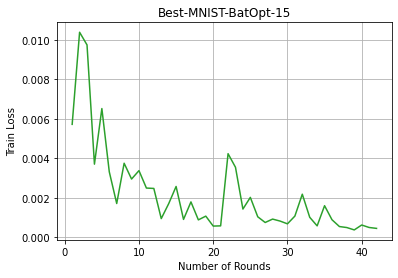

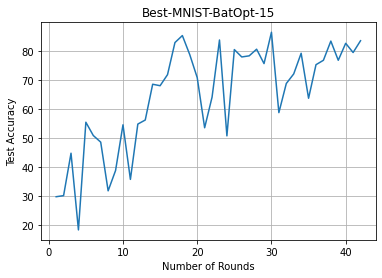

In [142]:
# number of training rounds
rounds = 100
# client fraction
CLIENT_FRACTION = 0.15
# number of clients
TOTAL_CLIENTS = 15
# number of training passes on local dataset for each round
TRAINING_EPOCHS = 5
# percentage of high power client
HIGHP_CLIENT_PERCENTAGE = 0.5
# number of training passes on local dataset for each round for low power client
LOWP_TRAINING_EPOCHS = 5
# batch size
batch_size = 10
# learning Rate
lr=0.01
# dict containing different type of data partition
data_dict = non_iid_partition(mnist_data_train, 15, 15, 4000, 1)
# data_dict = iid_partition(mnist_data_train, 100)
# load model
mnist_cnn = MNIST_CNN()
cifar_cnn = CIFAR_CNN()
mnist_cnn_s = MNIST_CNN_S()

if torch.cuda.is_available():
#   mnist_cnn.cuda()
  cifar_cnn.cuda()
  mnist_cnn_s.cuda()

mnist_cnn_non_iid_trained = training(cifar_cnn, rounds, batch_size, lr, mnist_data_train, data_dict, CLIENT_FRACTION, \
                                     TOTAL_CLIENTS, TRAINING_EPOCHS, LOWP_TRAINING_EPOCHS, HIGHP_CLIENT_PERCENTAGE, \
                                     "Best-MNIST-BatOpt-15", "green")
criterion = nn.CrossEntropyLoss()
testing(mnist_cnn_non_iid_trained, mnist_data_test, 128, criterion, num_classes, classes_test)

### Test

## MNIST CNN on 50/50

### Train